<a href="https://colab.research.google.com/github/pedro-de-bastos/cs156/blob/master/CS156_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS156 Assignment 3

Access my code and data on GitHub here:


## 1.) Importing and Cleaning Up the Data

In [169]:
## IMPORTING AND CLEANING UP THE DATA

import pandas as pd
from glob import glob
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np

data=pd.read_csv("/content/CRNS0101-05-2011-CA_Yosemite_Village_12_W.csv", header=None, low_memory=False)

#Adding label names from the README file and later to the PANDAS dataframe: 
headers = "WBANNO, UTC_DATE, UTC_TIME, LST_DATE, LST_TIME, CRX_VN, LONGITUDE, LATITUDE, AIR_TEMPERATURE, PRECIPITATION, SOLAR_RADIATION, SR_FLAG, SURFACE_TEMPERATURE, ST_TYPE, ST_FLAG, RELATIVE_HUMIDITY, RH_FLAG, SOIL_MOISTURE_5, SOIL_TEMPERATURE_5, WETNESS, WET_FLAG, WIND_1_5, WIND_FLAG"
headers = headers.split(",")

#Importing the data from the directory using glob() to get file names
filenames = files = glob('*.csv') 
for file in filenames:
  data = pd.concat([data, pd.read_csv(file, header=None, low_memory=False)])

#Adding the headers
data.columns = headers

#Important month length info for my date do day function
month_lenghts_2012_2016 = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

#Function that converts dates to 'day of the year out of 365', taking leap years
#into consideration
def date_to_day(date):
  year = str(date)[0:4]
  month = str(date)[4:6]
  day = str(date)[6:]
  if year == "2012" or year == "2016":
    num = sum(month_lenghts_2012_2016[0:int(month)-1])
    num = num + float(day)
  else:
    num = sum(month_lengths[0:int(month)-1])
    num = num + float(day)
  return num

#Funtion that converts hour of the day into minute of the day (out of 3600)
def hour_to_min(hour):
  if len(str(hour))==1:
    hour = "000"+str(hour)
  elif len(str(hour))==2:
    hour = "00"+str(hour)
  elif len(str(hour))==3:
    hour = "0"+str(hour)
  else:
    hour = str(hour)
  hours = hour[0:2]
  mins = hour[2:]
  num = float(hours)*60+float(mins)
  return num

#Function that turns strings into floats (and accounts for a cople of entries
#that are poorly added to the dataset
def string_to_float(str):
  try:
    return float(str)
  except:
    return float(str[0:4])

#Applying my functions to the date and time columns
data.columns
data[' LST_DATE'] = data[' LST_DATE'].apply(date_to_day)
data[' LST_TIME'] = data[' LST_TIME'].apply(hour_to_min)
data[' UTC_DATE'].apply(string_to_float)

#Note: I found that many entries in the data set had temperature as -999 and 
#-9999, so I removed these rows
data[' AIR_TEMPERATURE'] = data[' AIR_TEMPERATURE'].apply(string_to_float)
is_error = data[' AIR_TEMPERATURE'] == -999
data = data[~is_error]
is_error = data[' AIR_TEMPERATURE'] == -9999
data = data[~is_error]

#Here I separate data between training and testing sets, leaving 2016 as a train
#set:
data_test = data[data[' UTC_DATE']>20151231]
data_train = data[data[' UTC_DATE']<=20151231]

#Below I set a variable 'temps' to be our test for the predicted temps
temps_test = np.asarray(data_test[[' AIR_TEMPERATURE']]).reshape(-1, 1)
temps_train = np.asarray(data_train[[' AIR_TEMPERATURE']]).reshape(-1, 1)

630447

In short, my code above imports the data from the local directory, 'cleans up' oddly inputted entries, transforms times and dates into a more usable format as described in the assignment's prompt, and separates the data into test and training sets.

## 2.) Model Based on Date (Day Of the Year) Only

My approach to (a) choosing the number of RBFs that compose my model and (b) setting their centers was to first plot the data, and then, by visual inspection, infer where the 'bumps' lie. Then, my approach to choose the optimal 'sigma'(i.e. the 'width' of each bump) was to perform trial and error testing, using $R^2$ as my indicator of how well I was doing.

Score on training data =  0.5630452672852966
Score on test data =  0.5815430281875631


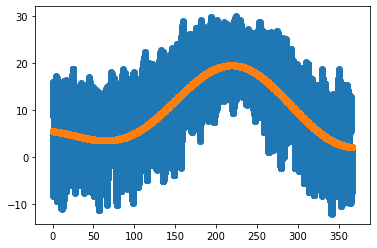

In [203]:
## MODEL BASED ON DATE (DAY OF THE YEAR) ONLY
days_train = np.asarray(data_train[[' LST_DATE']]).reshape(-1, 1)
days_test = np.asarray(data_test[[' LST_DATE']]).reshape(-1, 1)
centers_days = np.asarray([16, 40, 75, 125, 175, 225, 275, 325]).reshape(-1, 1)

alpha = 0.01
sigma_days = 30000

# New representation for days (train set):
x1_train = rbf_kernel(days_train, centers_days, gamma=1.0/sigma_days)

# New representation for days (test set):
x1_test = rbf_kernel(days_test, centers_days, gamma=1.0/sigma_days)

#Fitting a Ridge model
regr1 = Ridge(alpha=alpha, fit_intercept=False)
regr1.fit(x1_train, temps_train)

#Score on our training data
print("Score on training data = ", regr1.score(x1_train, temps_train))

#Score on our testing data
print("Score on test data = ", regr1.score(x1_test, temps_test))

#Predicting our temps in the train set (to visualize)
temp_predict = regr1.predict(x1_train)

#Plotting our predictions versus the real data
plt.scatter(days_train, temps_train)
plt.scatter(days_train, temp_predict)
plt.show()

The values for $R^2$ were $\approx0.56$ on the train set and $\approx 0.58$ on the test set. Note that I 'guessed and checked' the sigma based on how the graph looked, and on the $R^2$ results. Note that the fact that $R^2$ for the test set was larger gave me confidence that my model is not overfitting.

## 3.) Model Based on Hours (Minute of the Day) Only

To choose the number and position of centers, I used the same approach as above: I visually identified where the bumps would fit best based on a plot of the raw data.

Score on training data =  0.039624355988470916
Score on our testing data = 0.04075678398605587


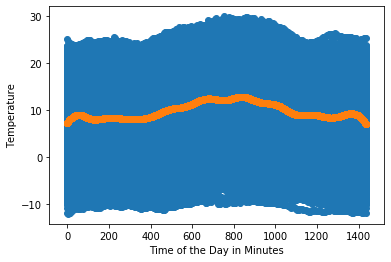

In [218]:
## MODEL BASED ON TIME OF DAY (IN MIN) ONLY
times_train = np.asarray(data_train[[' LST_TIME']]).reshape(-1, 1)
times_test = np.asarray(data_test[[' LST_TIME']]).reshape(-1, 1)

centers_times = np.asarray([50, 100, 175, 300, 400, 500, 610, 700, 830, 900, 1000, 1120, 1200, 1300, 1400]).reshape(-1, 1)

alpha = 0.01
sigma_times = 10000

#New representation for hours (train set):
x2_train = rbf_kernel(times_train, centers_times, gamma=1.0/sigma_times)

#New representation for hours (test set):
x2_test = rbf_kernel(times_test, centers_times, gamma=1.0/sigma_times)

#Fitting a Ridge model
regr2 = Ridge(alpha=alpha, fit_intercept=False)
regr2.fit(x2_train, temps_train)

#Score on our training data
print("Score on training data = ", regr2.score(x2_train, temps_train))

#Score on our testing data
print("Score on our testing data =", regr2.score(x2_test, temps_test))

#Predicting our temps in the train set (to visualize)
temp_predict = regr2.predict(x2_train)

#Plotting our predictions versus the real data
plt.scatter(times_train, temps_train)
plt.scatter(times_train, temp_predict)
plt.ylabel("Temperature")
plt.xlabel('Time of the Day in Minutes')
plt.show()

Again, to choose the best sigma I employed a 'guess and check' approach, wherein I attempted to find a local minima by noting how the rate of change of $R^2$ as a function of $\sigma$ was behaving. A more sophisticated approach would have been to code a function for $R^2$ as a function of $\sigma$ and use an optimization algorithm, like gradient climbing, to find a local maximum. That said, I stand by my 'guess and check' tactic because by guessing and checking I was able to find a strong convergence around $R^2\approx 0.04$, such that using an optimization algorithm might have yielded only a very marginal improvement. Note that the fact that $R^2$ was larger for the test set gave me confidence that my model was not overfitting.

# 4.) Model Based On Time and Date

In [219]:
## MODEL BASED ON TIME AND DATE

#Concatenating information for the training set into a single dataframe
X_1 = pd.DataFrame(x1_train)
X_2 = pd.DataFrame(x2_train)
Xs_train = pd.concat([X_1, X_2], axis=1)
ArrayXsTrain = np.asarray(Xs_train)

#Concatenating information for the testing set into a single dataframe
X_1 = pd.DataFrame(x1_test)
X_2 = pd.DataFrame(x2_test)
Xs_test = pd.concat([X_1, X_2], axis=1)
ArrayXsTest = np.asarray(Xs_test)

# Fitting a Linear Model
alpha = 0.01
regr = Ridge(alpha=alpha, fit_intercept=False)
regr.fit(ArrayXsTrain, temps_train)

#Score on our training data
print("Score on training data = ", regr.score(ArrayXsTrain, temps_train))

#Score on our test data
print("SCore on our test data =", regr.score(ArrayXsTest, temps_test))

Score on training data =  0.6042933285139387
SCore on our test data = 0.6258039869349391


To implement this model, I concatenated the representations for time and date (according to their respective RBF representations) and used that information to predict temperature. I used the values for $\sigma$ that I found in sections 2.) and 3.), assuming that the best representations for predicting temperature based on time only and on date only would, when used together, produce the best representation for temperature based on time AND date. This assumption relies on the patterns for temperature given time of day and temperature given hour of day remaining the same when we allow these variables to interact, but this is very likely an oversimplification. 

Nevertheless, knowing that these interactions may get very complicated, I decided that optimizing $\sigma$ independently for date and time was a staright-forward and effective stratedgy, but I recognize that a more sophisticated approach (like using a genetic algorithm to optimize for the interactions) might have yielded better results.

My $R^2$ results were also decent given this stratedgy: they were $\approx$0.60 for the training set and $\approx$0.63 for the test set. The fact that the test set has a higher $R^2$ score made me confident that I was not overfitting the data with my model.